<a href="https://colab.research.google.com/github/anasfarock/ForestFire/blob/main/ForestFire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Predict the burned area of forest fires**

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# 1. Data Exploration and Loading


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB
None

Descriptive Statistics:
                X           Y        FFMC         DMC          DC         ISI  \
count  517.000000  517.000000  517.000000  517.000000  517.000000  517.000000   
mean     4.669246    4.299807   90.644681  110.872340  547.940039    9.

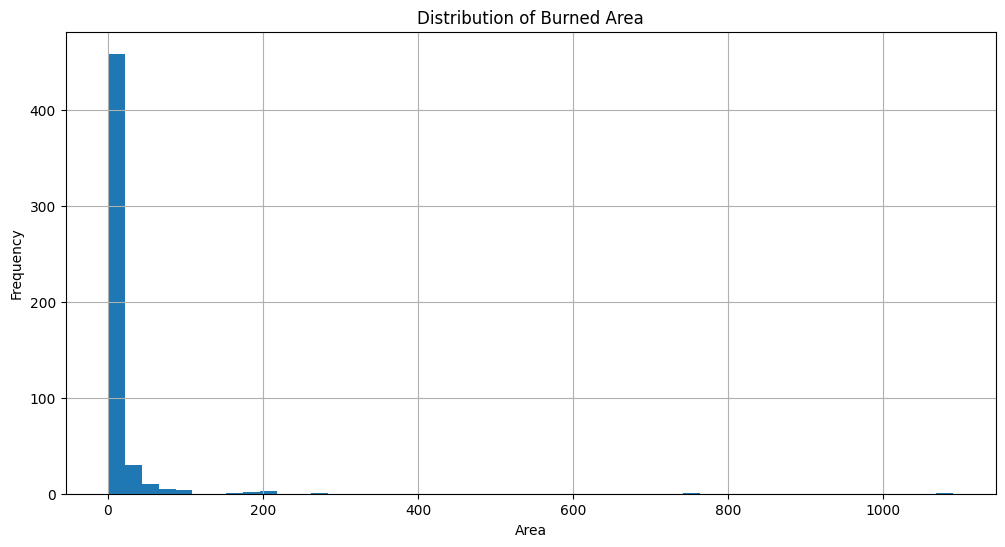

In [ ]:
# Load dataset
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv"
df = pd.read_csv(url)

# Explore the data
print("Dataset Info:")
print(df.info())
print("\nDescriptive Statistics:")
print(df.describe())

# Visualize distributions
plt.figure(figsize=(12, 6))
df['area'].hist(bins=50)
plt.title('Distribution of Burned Area')
plt.xlabel('Area')
plt.ylabel('Frequency')
plt.show()

# 2. Data Preprocessing

In [ ]:
# Handle categorical variables (month, day) with one-hot encoding
df_encoded = pd.get_dummies(df, columns=['month', 'day'], drop_first=True)

# Address skewed target variable (area)
df_encoded['area_log'] = np.log1p(df_encoded['area'])  # log1p to handle zeros

# Feature scaling for numerical features
numerical_cols = ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']
scaler = StandardScaler()
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

# Feature engineering: Add a binary weekend feature
df_encoded['is_weekend'] = df_encoded[['day_sat', 'day_sun']].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)

# 3. Splitting the Data

In [ ]:
X = df_encoded.drop(columns=['area', 'area_log'])  # Features
y = df_encoded['area_log']  # Target (log-transformed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Model Training

In [ ]:
# Baseline: Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Ensemble: Random Forest Regression
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Cross-validation
lr_cv_scores = cross_val_score(lr, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rf_cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"Linear Regression CV RMSE: {np.sqrt(-lr_cv_scores.mean()):.4f}")
print(f"Random Forest CV RMSE: {np.sqrt(-rf_cv_scores.mean()):.4f}")

Linear Regression CV RMSE: 1.5502
Random Forest CV RMSE: 1.4718


# 5. Model Evaluation

In [ ]:
# Predictions
y_pred_lr = lr.predict(X_test)
y_pred_rf = rf.predict(X_test)

# Metrics
print("\nLinear Regression Performance:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr)):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lr):.4f}")

print("\nRandom Forest Performance:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_rf):.4f}")


Linear Regression Performance:
RMSE: 1.5171
MAE: 1.2021

Random Forest Performance:
RMSE: 1.5317
MAE: 1.2134


# 6. Visualization and Interpretation

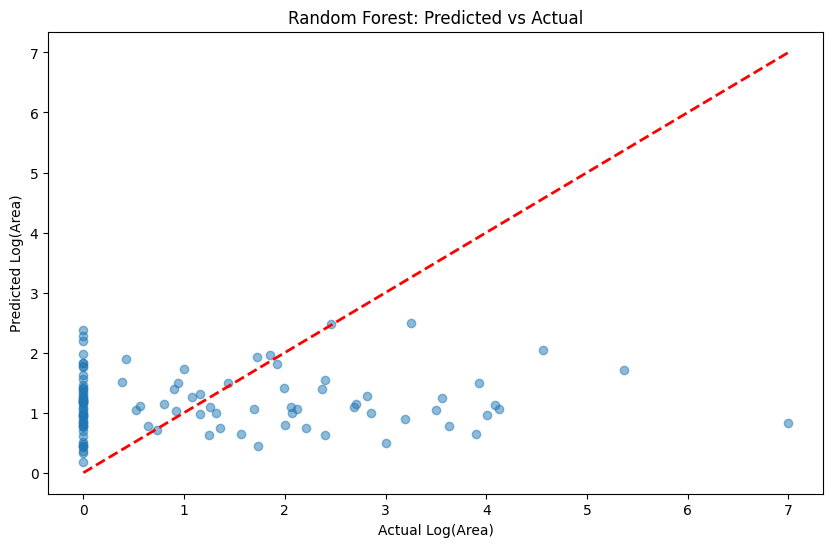

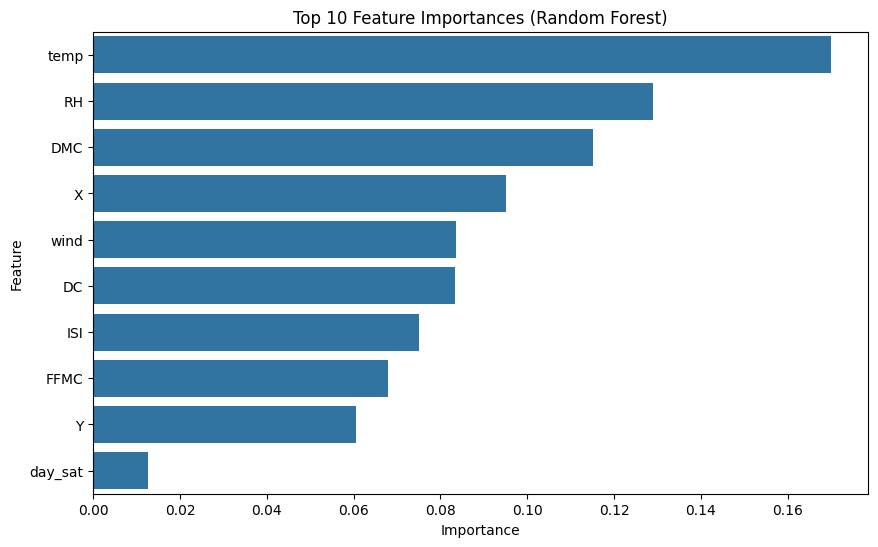

In [ ]:
# Scatter plot of predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Log(Area)')
plt.ylabel('Predicted Log(Area)')
plt.title('Random Forest: Predicted vs Actual')
plt.show()

# Feature importance (Random Forest)
importances = rf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Top 10 Feature Importances (Random Forest)')
plt.show()